In [25]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch
from itertools import product

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

import matplotlib
import pickle

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                                              compare_performance, plot_errors_dict,\
                                              torch_algo_wrapper,\
                                              plot_ratios_gpu_algo, plot_ratios_cpu_gpu, plot_ratios_cpu_algo,\
                                              plot_errors_dict, errors_at_time_t_over_inner_dim
                                                

In [ ]:
def time_for_n_steps_over_inner_dim_data_size(r_list, shape_list, n, algo): 
    time_data = np.zeros((len(r_list), len(shape_list))) 
    
    for r_i, r in enumerate(r_list):
        for sh_i, shape in enumerate(shape_list):
            V = get_random_lowrank_matrix(shape[0], r, shape[1])
            W_init, H_init = nmf.mult.update_empty_initials(V, r, None, None)
            W, H, errors = algo(V=V, inner_dim=r, 
                        record_errors=True,
                        time_limit=np.inf,
                        max_steps=n,
                        epsilon=0,
                        W_init=W_init.copy(),
                        H_init=H_init.copy()) 
            time_data[r_i, sh_i] = errors[n-1, 0]

    return time_data

In [ ]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [ ]:
inner_dim, shape = (200, (5000, 1000))
V = get_random_lowrank_matrix(shape[0], inner_dim, shape[1]) + 0.1 * np.random.rand(*shape)

In [ ]:
errors_over_r_random = pickle.load(open("errors_over_r_random.pkl","rb"))

In [ ]:
errors_over_r_random = errors_at_time_t_over_inner_dim(V, list(range(20, 300, 20)), 1200, 
                                                       {k:v for k,v in algo_dict_to_test.items() if "torch" in k})

In [ ]:
pickle.dump(errors_over_r_random,  open("errors_over_r_random.pkl","wb"))

In [ ]:
f, ax = plt.subplots()
plot_errors_dict(errors_over_r_random, ax, log=True, x_lbl="Inner dim", title="site3")

f, ax = plt.subplots()
plot_errors_dict(errors_over_r_random, ax, log=False, x_lbl="Inner dim", title="site3")

In [4]:
shapes = [(5 * a, a) for a in [30, 100, 300, 1000, 3000]]
shapes

[(150, 30), (500, 100), (1500, 300), (5000, 1000), (15000, 3000)]

In [5]:
inner_dims_small = [sh[1] // 10 for sh in shapes]
inner_dims_small

[3, 10, 30, 100, 300]

In [6]:
inner_dims_big = [8 * sh[1] // 10 for sh in shapes]
inner_dims_big

[24, 80, 240, 800, 2400]

In [7]:
shapes_all = shapes + shapes
inner_dims = inner_dims_small + inner_dims_big

In [8]:
times = [5, 25, 200, 1200, 8000]
times = times + [t * 2 for t in times]

In [9]:
print(len(shapes_all))

10


In [10]:
errors_dict = pickle.load(open("random_data_errors_dict.pkl","rb"))

In [ ]:
errors_dict = {}

In [ ]:
for inner_dim, shape, t  in zip(inner_dims, shapes_all, times):
    print((inner_dim, shape))
    if (inner_dim, shape) in errors_dict.keys():
        continue
        
    V = get_random_lowrank_matrix(shape[0], inner_dim, shape[1]) + np.random.rand(*shape) * 0.1

    W_init = np.random.rand(shape[0], inner_dim)
    H_init = np.random.rand(inner_dim, shape[1])

    errors = compare_performance(V=V, inner_dim=inner_dim, time_limit=t,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)
    errors_dict[(inner_dim, shape)] = errors
    pickle.dump(errors_dict,  open("random_data_errors_dict.pkl","wb"))

In [ ]:
pickle.dump(errors_dict,  open("random_data_errors_dict.pkl","wb"))

In [11]:
keys = zip(inner_dims, shapes_all)
keys = sorted(keys, key=lambda k: k[0])
keys = sorted(keys, key=lambda k: k[1][0])

In [12]:
keys

[(3, (150, 30)),
 (24, (150, 30)),
 (10, (500, 100)),
 (80, (500, 100)),
 (30, (1500, 300)),
 (240, (1500, 300)),
 (100, (5000, 1000)),
 (800, (5000, 1000)),
 (300, (15000, 3000)),
 (2400, (15000, 3000))]

<IPython.core.display.Javascript object>


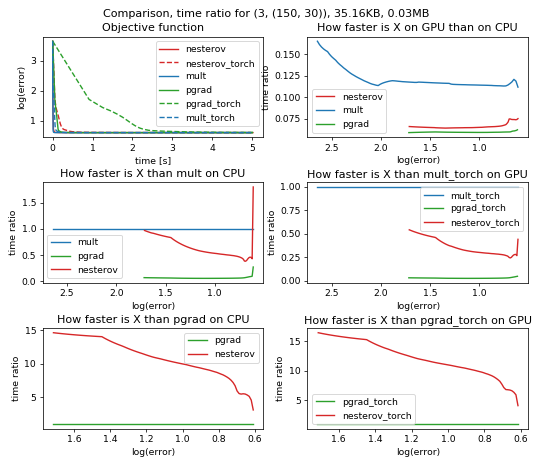

<IPython.core.display.Javascript object>


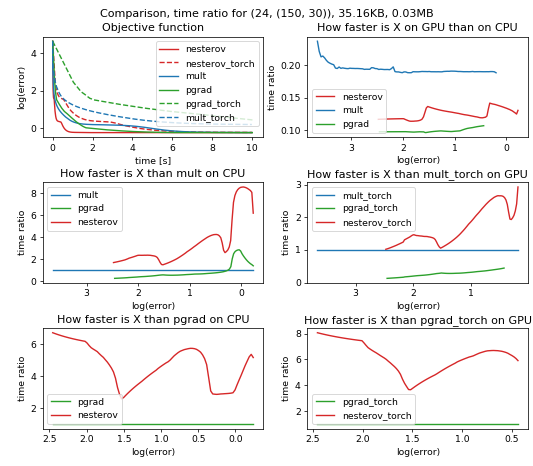

<IPython.core.display.Javascript object>


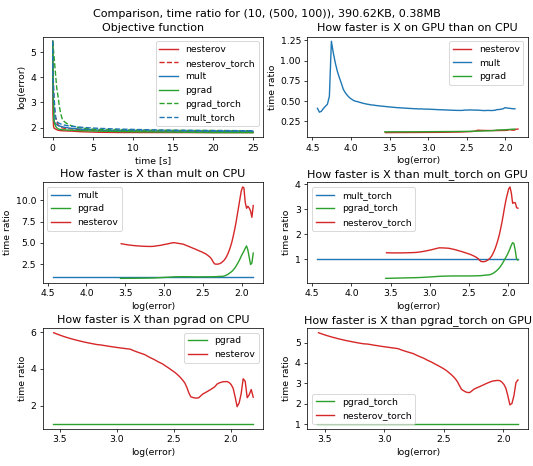

<IPython.core.display.Javascript object>


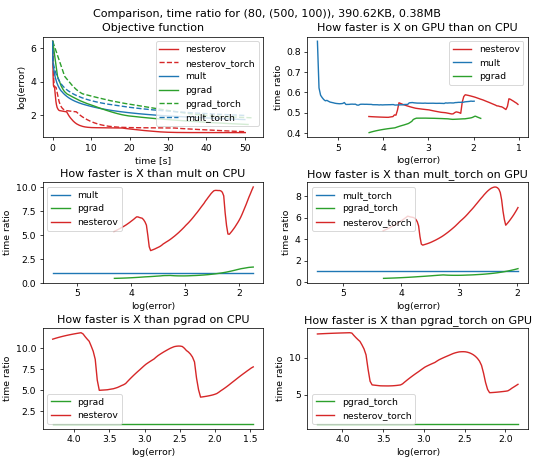

<IPython.core.display.Javascript object>


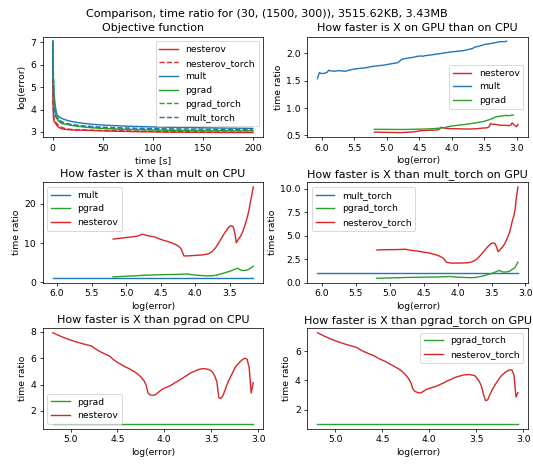

<IPython.core.display.Javascript object>


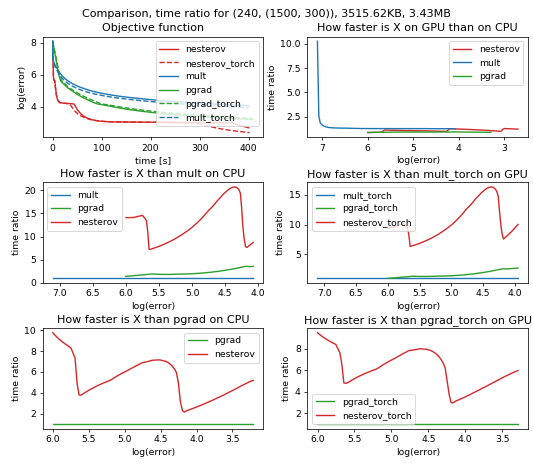

<IPython.core.display.Javascript object>


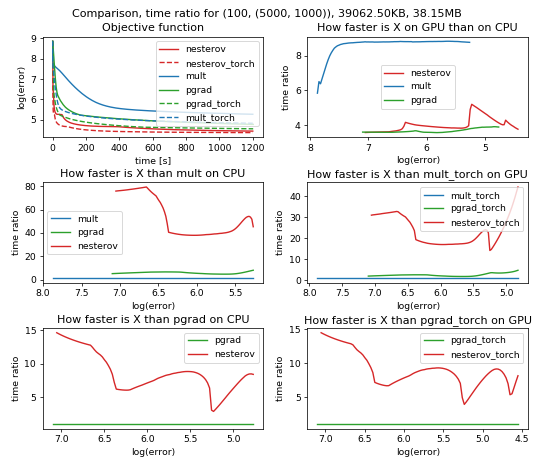

<IPython.core.display.Javascript object>


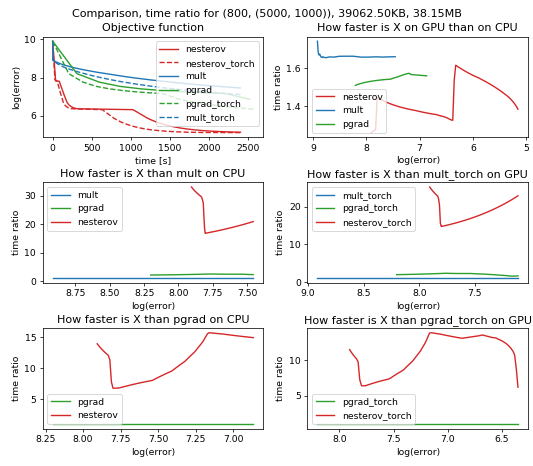

<IPython.core.display.Javascript object>


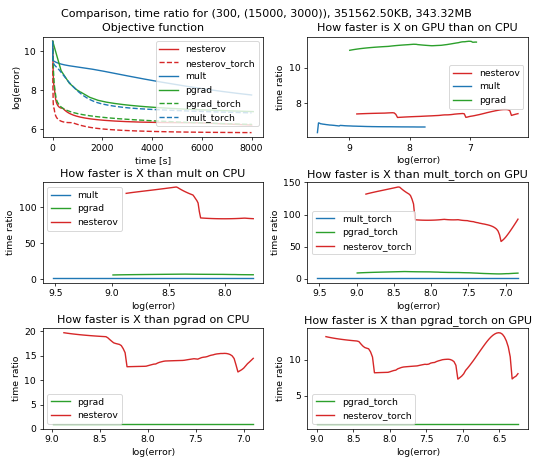

<IPython.core.display.Javascript object>


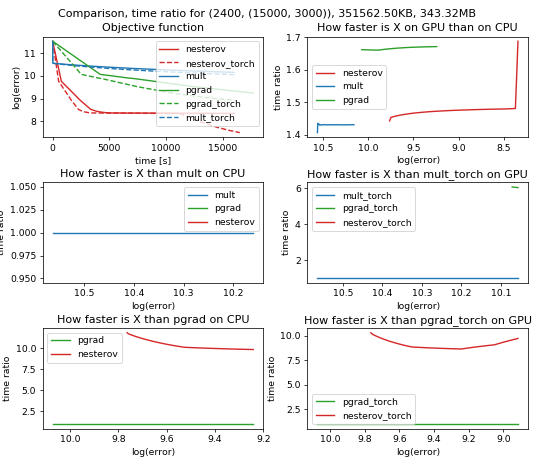

In [16]:
for k in keys:
    r, shape = k
    M = np.random.rand(shape[0], r) @ np.random.rand(r, shape[1])

    errros_dict_particular_data = errors_dict[k]

    f, axes = plt.subplots(3, 2, figsize=(8, 7), dpi=100, gridspec_kw=dict(hspace=0.45, top=0.92, bottom=0.08, 
                                                                  left=0.08, right=0.99))
    f.suptitle("Comparison, time ratio for {}, {:.2f}KB, {:.2f}MB".format(k, M.nbytes / 2**10, M.nbytes / 2**20))

    plot_errors_dict(errros_dict_particular_data, axes[0, 0], log=True, title="Objective function", x_lbl="time [s]")

    plot_ratios_cpu_gpu(errros_dict_particular_data, axes[0, 1])
    plot_ratios_cpu_algo(errros_dict_particular_data, axes[1:, 0], selected_algs=["mult", "pgrad", "nesterov"])
    plot_ratios_gpu_algo(errros_dict_particular_data, axes[1:, 1],
                         selected_algs=["mult_torch", "pgrad_torch", "nesterov_torch"])

In [ ]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 1}

matplotlib.rc('font', **font)

f, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=100, 
                       gridspec_kw=dict(wspace=0.35, hspace=0.6,
                                        top=0.85,
                                        bottom=0.1,
                                        left=0.1, right=0.95))
f.suptitle("Ratio between time it takes to reach particular cost function value on CPU and on GPU")

axes = list(axes.T.ravel())

a11, a21, a12, a22, a13, a23 = axes

a11.get_shared_y_axes().join(a11, a12, a13)
a21.get_shared_y_axes().join(a21, a22, a23)


legend_is = False
for k, a in zip(keys, axes):
    print(k)
    r, shape = k
    plot_ratios_cpu_gpu(errors_dict[k], a)
    
    M = np.random.rand(shape[0], r) @ np.random.rand(r, shape[1])
    kb = M.nbytes / 2**10 
    mb = M.nbytes / 2**20
    
    if mb < 1:
        size = "{:.2f}KB".format(kb)  
    else:
        size = "{:.2f}MB".format(mb)  
        
    a.set_title("factorization of size {}\nmat. shape {} {}".format(k[0], k[1], size))
    
    if legend_is:
        a.get_legend().remove()
    else:
        legend_is = True

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=200,
                       gridspec_kw=dict(wspace=0.35, hspace=0.6,
                                        top=0.85,
                                        bottom=0.1,
                                        left=0.1, right=0.95))
f.suptitle("Ratio between time it takes to reach particular cost function value on CPU and on GPU")

axes = list(axes.T.ravel())

a11, a12, a21, a22 = axes

a11.get_shared_y_axes().join(a11, a21)
a12.get_shared_y_axes().join(a12, a22)


legend_is = False
for k, a in zip(keys[6:], axes):
    print(k)
    r, shape = k
    plot_ratios_cpu_gpu(errors_dict[k], a)
    
    M = np.random.rand(shape[0], r) @ np.random.rand(r, shape[1])
    kb = M.nbytes / 2**10 
    mb = M.nbytes / 2**20
    
    if mb < 1:
        size = "{:.2f}KB".format(kb)  
    else:
        size = "{:.2f}MB".format(mb)  
        
    a.set_title("factorization of size {}\nmatrix of shape {}, size {}".format(k[0], k[1], size))
    
    if legend_is:
        a.get_legend().remove()
    else:
        legend_is = True

<IPython.core.display.Javascript object>


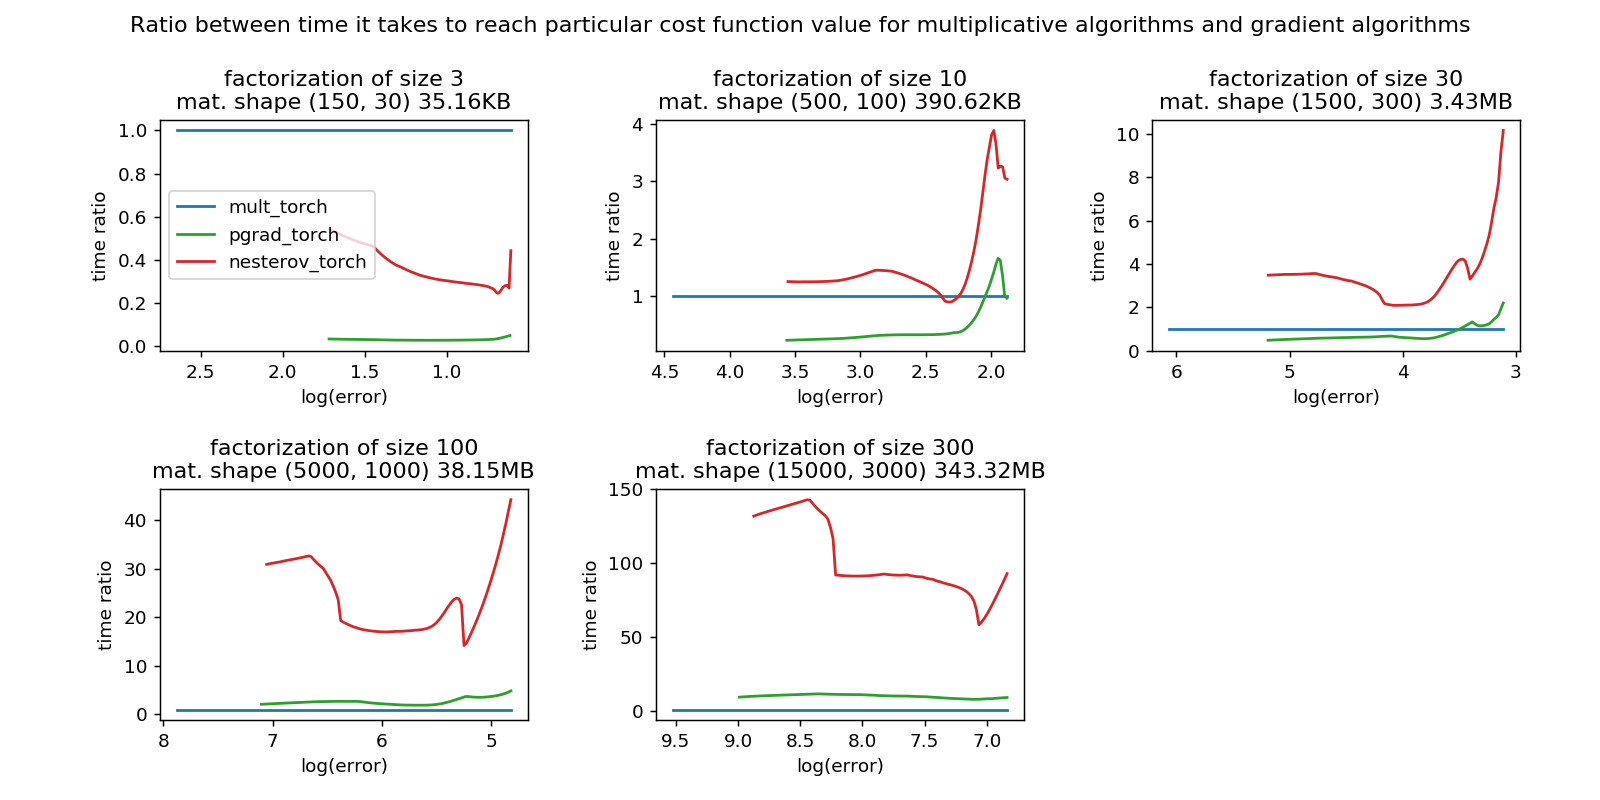

<IPython.core.display.Javascript object>


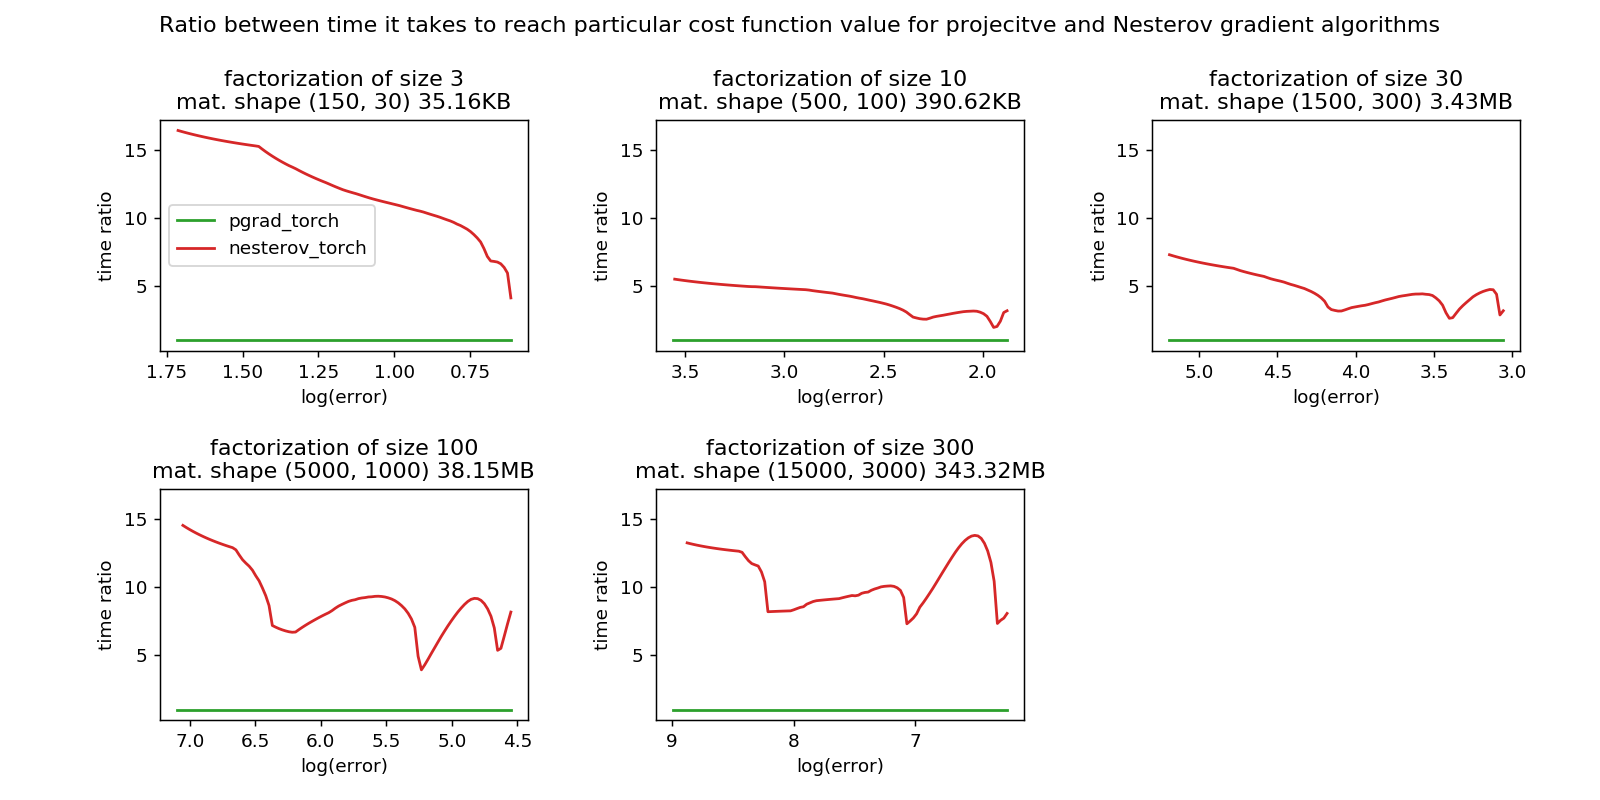

[(3, (150, 30)), (24, (150, 30)), (10, (500, 100)), (80, (500, 100)), (30, (1500, 300)), (240, (1500, 300)), (100, (5000, 1000)), (800, (5000, 1000)), (300, (15000, 3000)), (2400, (15000, 3000))]
6
6


In [37]:
f, axes1 = plt.subplots(2, 3, figsize=(12, 6), dpi=200, 
                       gridspec_kw=dict(wspace=0.35, hspace=0.6,
                                        top=0.85,
                                        bottom=0.1,
                                        left=0.1, right=0.95))
f.suptitle("Ratio between time it takes to reach particular "+
           "cost function value for multiplicative algorithms and gradient algorithms")


f, axes2 = plt.subplots(2, 3, figsize=(12, 6), dpi=200, 
                       gridspec_kw=dict(wspace=0.35, hspace=0.6,
                                        top=0.85,
                                        bottom=0.1,
                                        left=0.1, right=0.95))
f.suptitle("Ratio between time it takes to reach particular cost function value for projecitve and Nesterov gradient algorithms")


axes1 = list(axes1.ravel())
axes2 = list(axes2.ravel())

axes1[-1].set_axis_off()
axes2[-1].set_axis_off()


# axes1[0].get_shared_y_axes().join(*axes1)
axes2[0].get_shared_y_axes().join(*axes2)

print(keys)
print(len(axes1))
print(len(axes2))

legend_is = False
for k, a1, a2 in zip(keys[::2], axes1, axes2):
    r, shape = k
    
    if r != 0.1 * shape[1]:
        print(k)
        continue
    
    plot_ratios_gpu_algo(errors_dict[k], [a1, a2],
                         selected_algs=["mult_torch", 
                                        "pgrad_torch",
                                        "nesterov_torch"])
    
    M = np.random.rand(shape[0], r) @ np.random.rand(r, shape[1])
    kb = M.nbytes / 2**10 
    mb = M.nbytes / 2**20
    
    if mb < 1:
        size = "{:.2f}KB".format(kb)  
    else:
        size = "{:.2f}MB".format(mb)  
        
    a1.set_title("factorization of size {}\nmat. shape {} {}".format(k[0], k[1], size))
    a2.set_title("factorization of size {}\nmat. shape {} {}".format(k[0], k[1], size))
    
    if legend_is:
        a1.get_legend().remove()
        a2.get_legend().remove()
    else:
        legend_is = True

In [33]:
l = [0, 1, 2, 3, 4, 5, 6, 7, 8]

In [34]:
l[::2]

[0, 2, 4, 6, 8]